In [156]:
import cv2
import numpy as np
import os
import natsort
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [16, 9]

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_percentage_error

In [169]:
#Função que transforma a Imagem 1d em uma reconstrução da Imagem 2D da qual a foto foi tirada
def untransform(result):
    canvas=np.ones((result.shape[1],result.shape[1],3), np.uint8)
    canvas=canvas*255
    for index, x in enumerate(result[0]):
        canvas[0:x[3],index,:]=[x[0],x[1],x[2]]
    	
    canvas = cv2.flip(canvas, 0)
    return canvas


#arredondar um numero para seu inteiro mais proximo
def proper_round(num):
    num_floor=np.floor(num)
    num_ceil=np.ceil(num)
    dif_floor=np.absolute(num-num_floor)
    dif_ceil=np.absolute(num-num_ceil)
    if dif_floor<=dif_ceil:
        return num_floor
    else:
        return num_ceil
    


## Abordagem 1: Divisão da Integral

Nesse metodo, pegamos a profundidade de cada pixel e integramos para descobrir a área debaixo da curva definida

Em seguida, dividimos a área pela área de uma peça original

### Função Integradora da Imagem 1D

In [110]:
def Image1DAreaIntegral(pict):
    #integral de todos os valores de profundidade subtraido da barra da caixa que aparece como dois pixels cinzas no canto esquerdo
    return np.sum(pict[0,:,3])-2046 

#Função para estimar usando a área real das peças, porque sabemos que a area integrada em Image1DAreaIntegral
#de uma peça é sempre maior ou igual a área real dessa peça
def EstimaPecas1(pict,area_de_uma_peca):
    area_estimada=Image1DAreaIntegral(pict)
    pecas_estimadas=area_estimada/area_de_uma_peca
    return int(np.floor(pecas_estimadas))



#Função para estimar usando a área já estimada de uma peça pela camera 1D, usamos o valor mais proximo para o resultado
def EstimaPecas2(pict,area_de_uma_peca):
    area_estimada=Image1DAreaIntegral(pict)
    pecas_estimadas=area_estimada/area_de_uma_peca
    return int(proper_round(pecas_estimadas))
    
    

### Encontrando a Area das peças originais

figura 2D


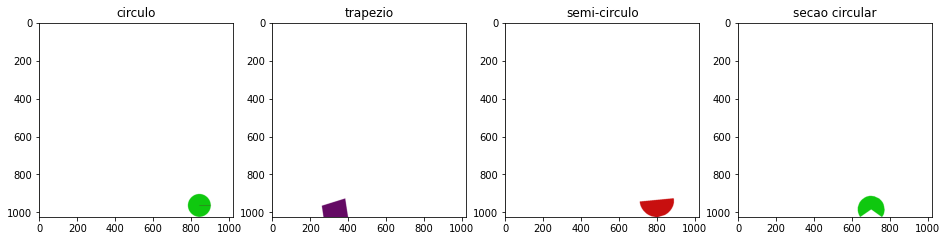

recortes especificos para cada peça no formato [xmin,xmax,ymin,ymax]


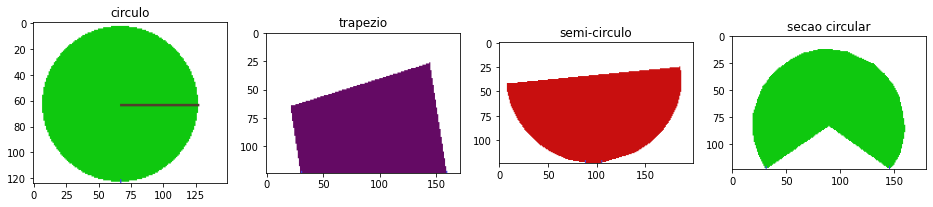

treshold para igualar todos os valores e deixar preto e branco solido


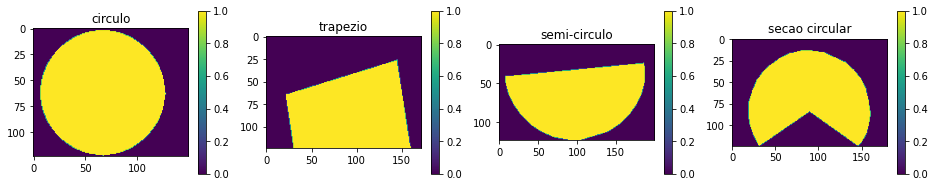

Areas das figuras
{'circulo': 11259, 'trapezio': 10101, 'semi-circulo': 12731, 'secao circular': 10830}


In [50]:
formas=['circulo', 'trapezio', 'semi-circulo', 'secao circular']
arquivos=['Caixa_C/caixa000_qtd01.png','Caixa_V/caixa000_qtd01.png',
          'Caixa_D/caixa003_qtd01.png','Caixa_L/caixa001_qtd01.png']

print('figura 2D')
plt.figure()
for x in range(len(formas)):
    image =cv2.imread(arquivos[x])
    plt.subplot(1, 4, x+1)
    plt.imshow(image)
    plt.title(formas[x])   
plt.show()
    
#recortes especificos para cada peça no formato [xmin,xmax,ymin,ymax]
print('recortes especificos para cada peça no formato [xmin,xmax,ymin,ymax]')
ranges=[[775,925,900,1024],[240,412,900,1024],[700,900,900,1024],[610,790,900,1024]]

plt.figure()
for x in range(len(ranges)):
    image =cv2.imread(arquivos[x])
    image= image[ranges[x][2]:ranges[x][3],ranges[x][0]:ranges[x][1],:]
    plt.subplot(1, 4, x+1)
    plt.imshow(image)
    plt.title(formas[x])   
plt.show()

print('treshold para igualar todos os valores e deixar preto e branco solido')
areas={}
plt.rcParams['figure.figsize'] = [16, 3]
plt.figure()
for x in range(len(ranges)):
    image =cv2.imread(arquivos[x])
    image= image[ranges[x][2]:ranges[x][3],ranges[x][0]:ranges[x][1],:]
    image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,image = cv2.threshold(image,254,1,cv2.THRESH_BINARY_INV)
    areas[formas[x]]=np.sum(image.flatten())
    plt.subplot(1, 4, x+1)
    plt.imshow(image)
    plt.colorbar()
    plt.title(formas[x])   
plt.show()
plt.rcParams['figure.figsize'] = [16, 9]

print('Areas das figuras')
print(areas)





Uma outra hipotese que devemos averiguar é se podemos obter melhores métricas usando como area para divisão a area gerada pela *visão da camera*, que é essencialmente considerar a area da peça+a área debaixo da peça como a area de divisão

figura 2D


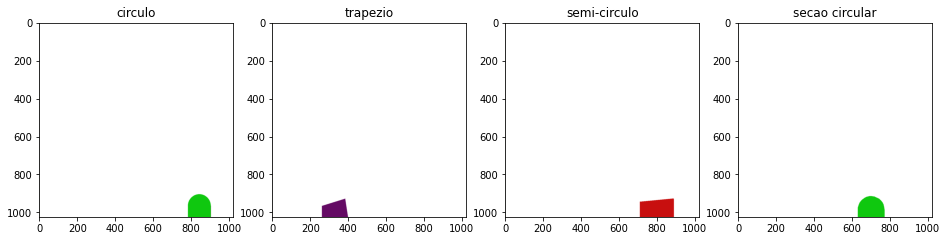

recortes especificos para cada peça no formato [xmin,xmax,ymin,ymax]


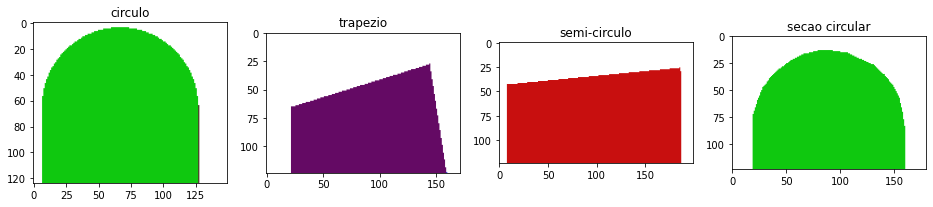

treshold para igualar todos os valores e deixar preto e branco solido


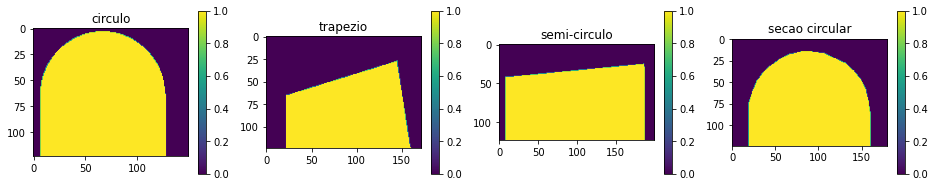

Areas das figuras
{'circulo': 12888, 'trapezio': 10200, 'semi-circulo': 15937, 'secao circular': 13289}


In [51]:
formas=['circulo', 'trapezio', 'semi-circulo', 'secao circular']
arquivos=['circle/01/caixa000_qtd01.npy','trapezoid/01/caixa000_qtd01.npy',
          'half_circle/01/caixa003_qtd01.npy','c_sector/01/caixa001_qtd01.npy']

print('figura 2D')
plt.figure()
for x in range(len(formas)):
    pict=np.load(arquivos[x])
    image=untransform(pict)
    plt.subplot(1, 4, x+1)
    plt.imshow(image)
    plt.title(formas[x])   
plt.show()
    
#recortes especificos para cada peça no formato [xmin,xmax,ymin,ymax]
print('recortes especificos para cada peça no formato [xmin,xmax,ymin,ymax]')
ranges=[[775,925,900,1024],[240,412,900,1024],[700,900,900,1024],[610,790,900,1024]]

plt.figure()
for x in range(len(ranges)):
    pict=np.load(arquivos[x])
    image=untransform(pict)
    image= image[ranges[x][2]:ranges[x][3],ranges[x][0]:ranges[x][1],:]
    plt.subplot(1, 4, x+1)
    plt.imshow(image)
    plt.title(formas[x])   
plt.show()

print('treshold para igualar todos os valores e deixar preto e branco solido')
areas={}
plt.rcParams['figure.figsize'] = [16, 3]
plt.figure()
for x in range(len(ranges)):
    pict=np.load(arquivos[x])
    image=untransform(pict)
    image= image[ranges[x][2]:ranges[x][3],ranges[x][0]:ranges[x][1],:]
    image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,image = cv2.threshold(image,254,1,cv2.THRESH_BINARY_INV)
    areas[formas[x]]=np.sum(image.flatten())
    plt.subplot(1, 4, x+1)
    plt.imshow(image)
    plt.colorbar()
    plt.title(formas[x])   
plt.show()
plt.rcParams['figure.figsize'] = [16, 9]
print('Areas das figuras')
print(areas)




### Encontrando a Area das peças originais: Resultado
Deixamos esses resultados salvos para não ficar rodando isso sempre:


In [66]:
area_real=     {'circulo': 11259, 'trapezio': 10101, 'semi-circulo': 12731, 'secao circular': 10830}
area_projetada={'circulo': 12888, 'trapezio': 10200, 'semi-circulo': 15937, 'secao circular': 13289}

### Aplicando o algoritmo nas fotos

circulo
Precisão com a divisão pela área original: 0.14269073966220153
Erro Percentual Médio Absoluto com a divisão pela área original: 14.2%
Precisão com a divisão pela área projetada: 0.36206561832653855
Erro Percentual Médio Absoluto com a divisão pela área projetada: 2.9%


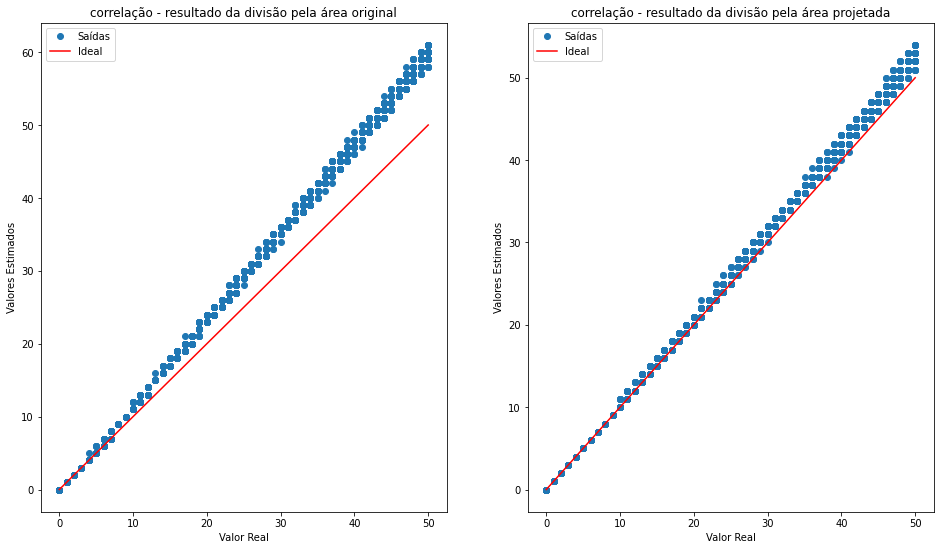

trapezio
Precisão com a divisão pela área original: 0.22927586876334693
Erro Percentual Médio Absoluto com a divisão pela área original: 9.3%
Precisão com a divisão pela área projetada: 0.17647058823529413
Erro Percentual Médio Absoluto com a divisão pela área projetada: 9.9%


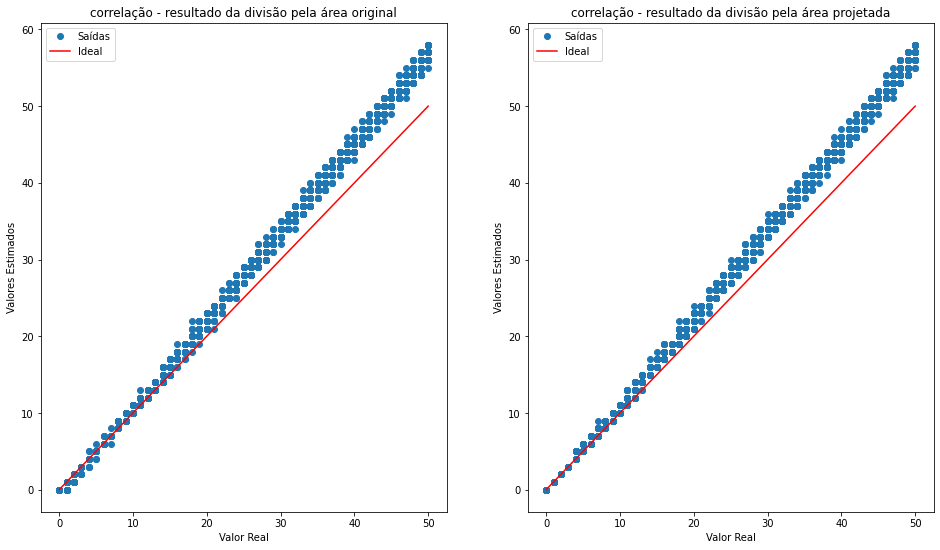

secao circular
Precisão com a divisão pela área original: 0.1147350029120559
Erro Percentual Médio Absoluto com a divisão pela área original: 13.1%
Precisão com a divisão pela área projetada: 0.25373713841972434
Erro Percentual Médio Absoluto com a divisão pela área projetada: 3.8%


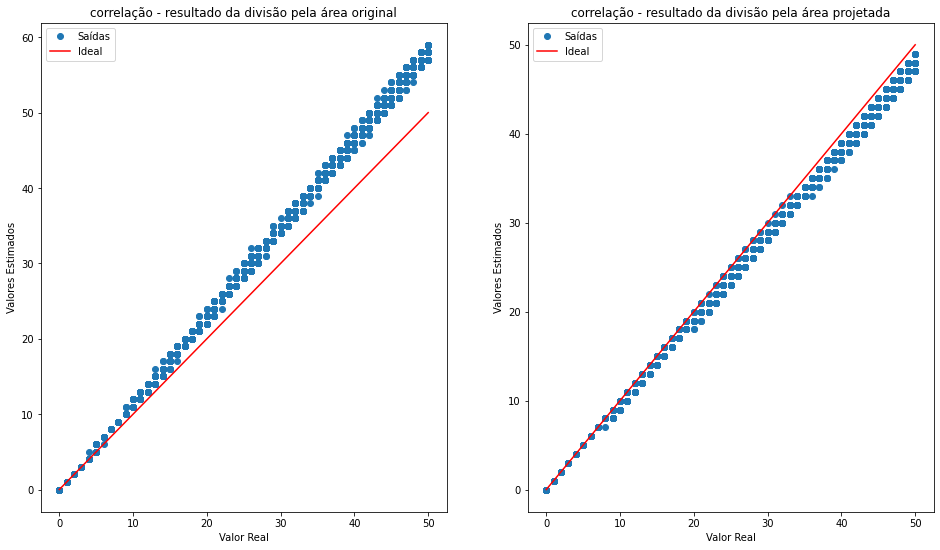

semi-circulo
Precisão com a divisão pela área original: 0.1768588623568239
Erro Percentual Médio Absoluto com a divisão pela área original: 11.0%
Precisão com a divisão pela área projetada: 0.09823335274703941
Erro Percentual Médio Absoluto com a divisão pela área projetada: 8.9%


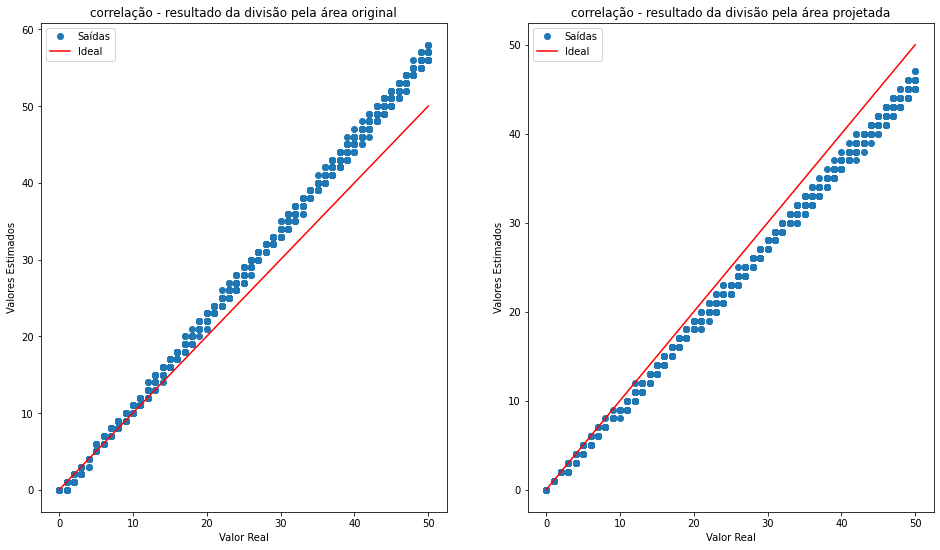

In [145]:
datasets=['circle/circle.json','trapezoid/trapezoid.json',
          'c_sector/c_sector.json','half_circle/half_circle.json']
area_alvo=['circulo','trapezio','secao circular','semi-circulo']

plotfigure=False
plotassign=True

for macroindex in range(len(datasets)):
    df = pd.read_json(datasets[macroindex])

    dfdictlist=[]    
    for index, row in df.iterrows():
        newrow={}
        newrow['file']=row['file']


        pict=np.load(row['file'])
        correct=int(row['Y'])
        estimativa1=EstimaPecas1(pict,area_real[area_alvo[macroindex]])
        estimativa2=EstimaPecas2(pict,area_projetada[area_alvo[macroindex]])

        newrow['Y_est_ar']=estimativa1
        newrow['Y_est_ap']=estimativa2

        newrow['Y']=row['Y']

        dfdictlist.append(newrow)
        
    print(area_alvo[macroindex])
    df2 = pd.DataFrame.from_dict(dfdictlist)

    accuracy=accuracy_score(df2['Y'],df2['Y_est_ar'])
    MAPE=mean_absolute_percentage_error(df2['Y'], df2['Y_est_ar'])
    print('Precisão com a divisão pela área original:',accuracy)
    print('Erro Percentual Médio Absoluto com a divisão pela área original:',f'{MAPE:.1%}')
    accuracy=accuracy_score(df2['Y'],df2['Y_est_ap'])
    MAPE=mean_absolute_percentage_error(df2['Y'], df2['Y_est_ap'])
    print('Precisão com a divisão pela área projetada:',accuracy)
    print('Erro Percentual Médio Absoluto com a divisão pela área projetada:',f'{MAPE:.1%}')
    if plotfigure == True:
        plt.rcParams['figure.figsize'] = [16,16] 
        print('Matriz de confusão com divisão pela área original')
        plt.figure()  
        cm_1 = ConfusionMatrixDisplay.from_predictions(y_true=df2['Y'], y_pred=df2['Y_est_ar'],colorbar=False)
        plt.show()
        print('Matriz de confusão com divisão pela área projetada')
        plt.figure()  
        cm_1 = ConfusionMatrixDisplay.from_predictions(y_true=df2['Y'], y_pred=df2['Y_est_ap'],colorbar=False)
        plt.show()
    if plotassign == True:
        plt.rcParams['figure.figsize'] = [16, 9] 
        plt.figure()  
        plt.subplot(1, 2, 1)
        x1 = df2['Y'].to_numpy()
        y1 = df2['Y_est_ar'].to_numpy()
        plt.plot(x1, y1, 'o', label='Saídas')
        plt.plot([0,50], [0,50], 'r-', label='Ideal')
        plt.xlabel('Valor Real');
        plt.ylabel('Valores Estimados');
        plt.title('correlação - resultado da divisão pela área original');
        plt.legend();
        plt.subplot(1, 2, 2)
        x1 = df2['Y'].to_numpy()
        y1 = df2['Y_est_ap'].to_numpy()
        plt.plot(x1, y1, 'o', label='Saídas')
        plt.plot([0,50], [0,50], 'r-', label='Ideal')
        plt.xlabel('Valor Real');
        plt.ylabel('Valores Estimados');
        plt.title('correlação - resultado da divisão pela área projetada');
        plt.legend();
        plt.show()
        
        
plt.rcParams['figure.figsize'] = [16, 9] 


## Abordagem 2: Coeficiente da Integral
Nesse metodo, tentamos estabelecer um coeficiente sobre a integral da profundidade da foto 1D que infere a quantidade de peças pelo volume ocupado, já que eles são diretamente proporcionais.

Isso poderia ser estabelecido via tentativa e erro, mas nesse cenário, vamos usar a regressão linear para encontrar esse coeficiente ideal.

In [ ]:
from sklearn.linear_model import LinearRegression


### Função Integradora da Imagem 1D

In [146]:
def Image1DAreaIntegral(pict):
    #integral de todos os valores de profundidade subtraido da barra da caixa que aparece como dois pixels cinzas no canto esquerdo
    return np.sum(pict[0,:,3])-2046 
    
    

### Aplicando o Algoritmo nas fotos

circulo
train 153
test 4998
b = 0.26558252371239277, w = [7.37020783e-05]
Precisão com regressão linear da integral: 0.8991596638655462
Erro Percentual Médio Absoluto com regressão linear da integral: 0.3%
Matriz de confusão com regressão linear da integral


<Figure size 1800x1800 with 0 Axes>

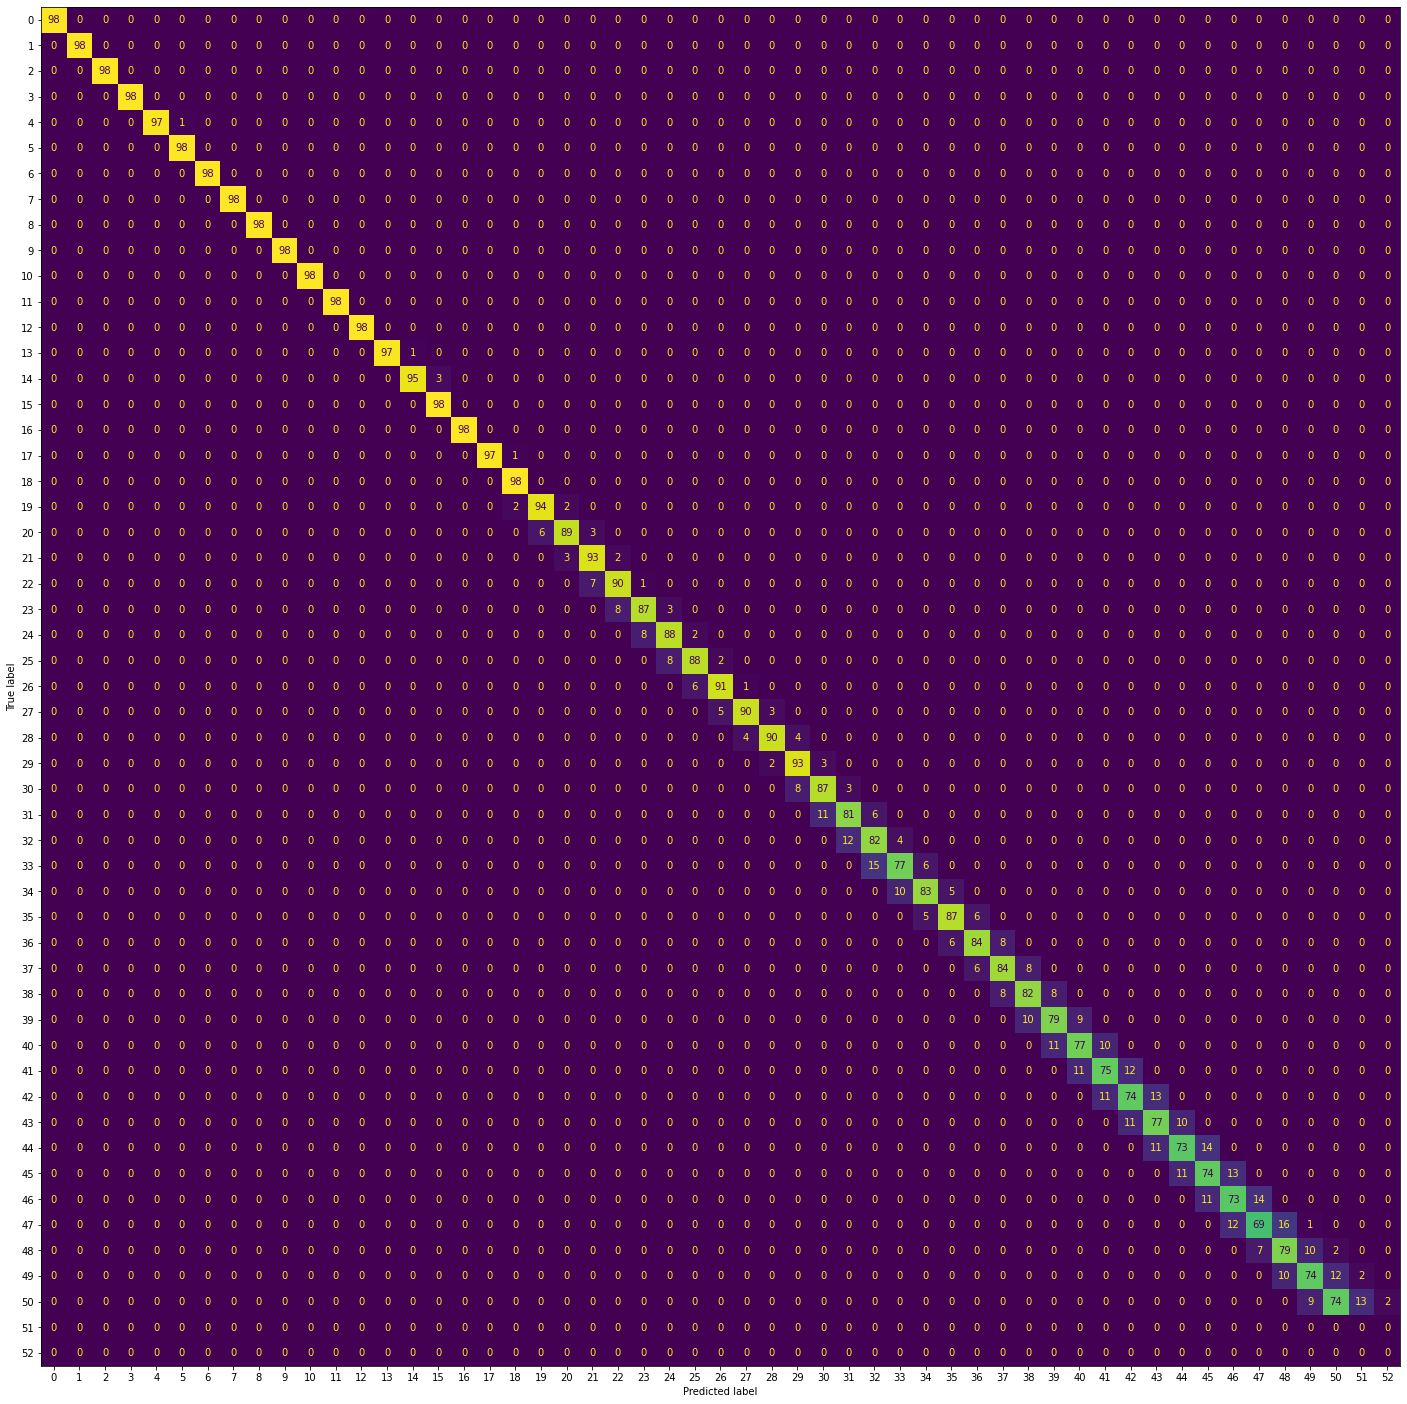

trapezio
train 153
test 4998
b = 0.5241065233969486, w = [8.65895982e-05]
Precisão com regressão linear da integral: 0.6974789915966386
Erro Percentual Médio Absoluto com regressão linear da integral: 8830587504648031.0%
Matriz de confusão com regressão linear da integral


<Figure size 1800x1800 with 0 Axes>

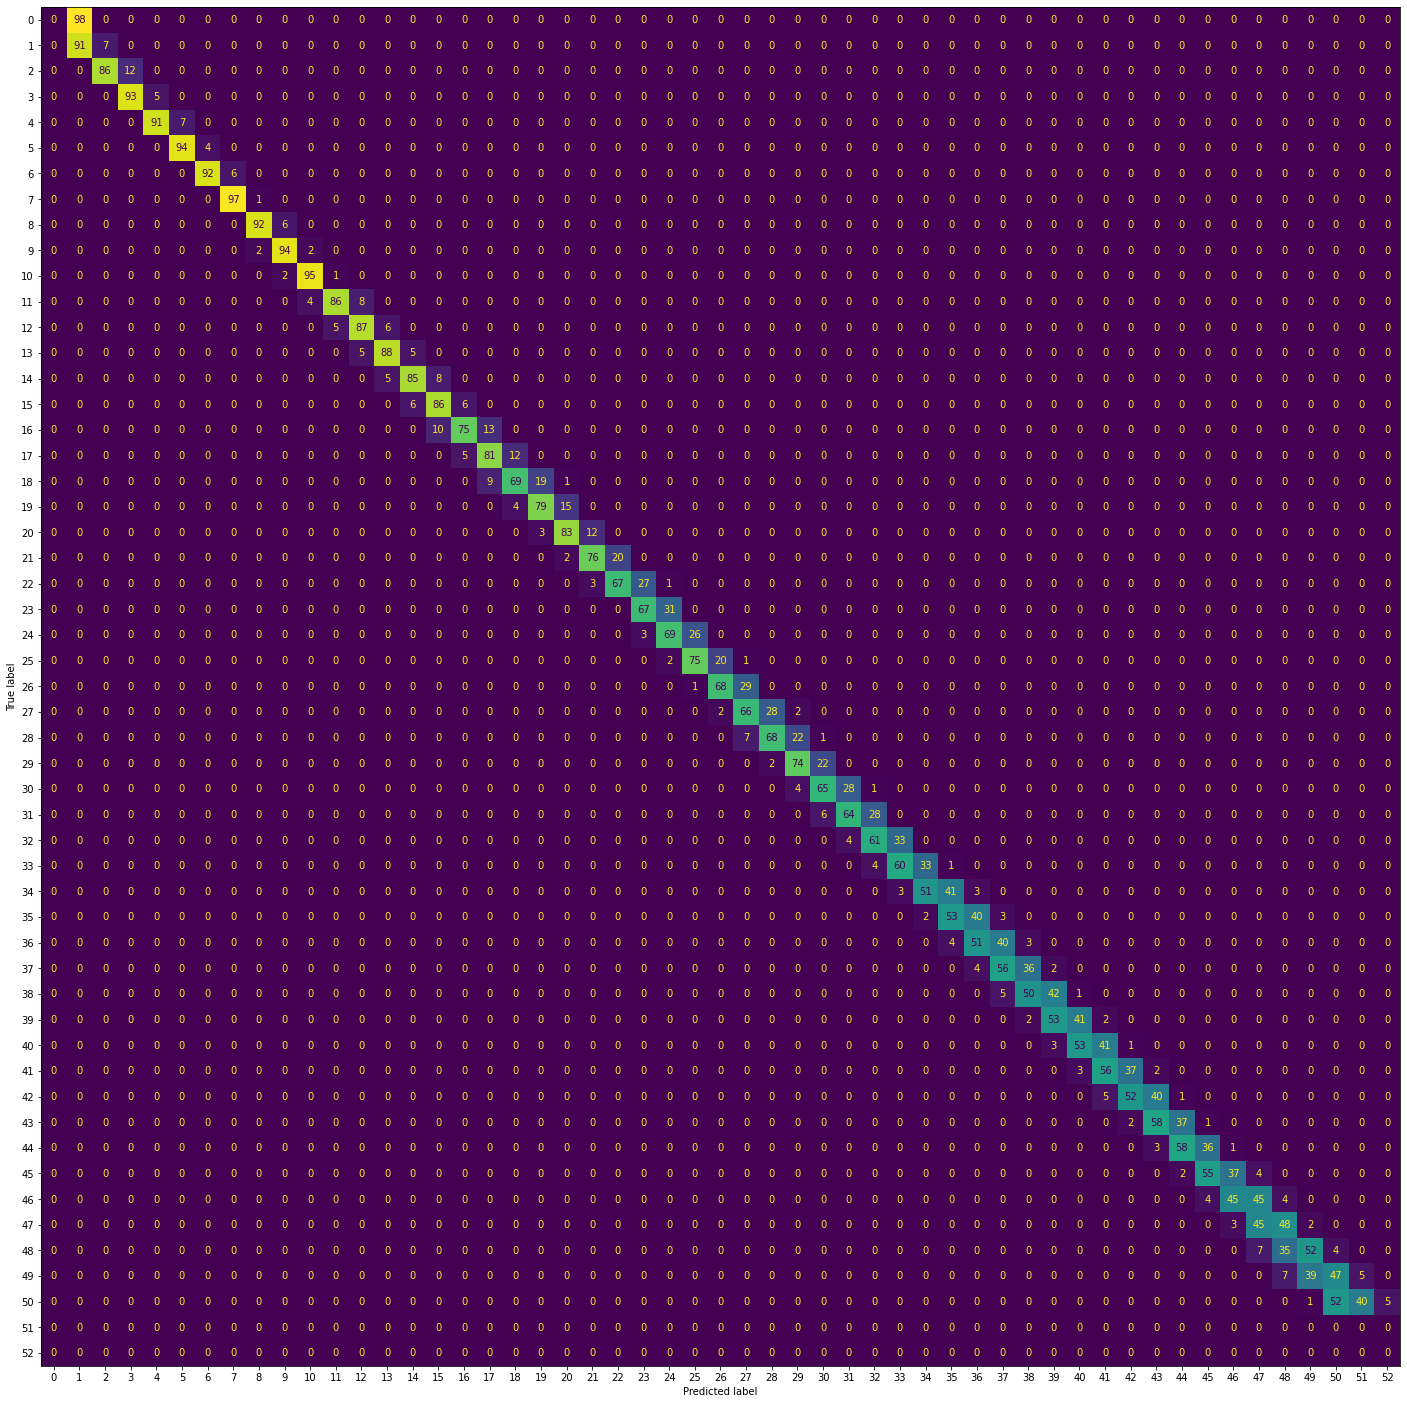

secao circular
train 153
test 4998
b = 0.03568452494295116, w = [7.87509785e-05]
Precisão com regressão linear da integral: 0.8363345338135254
Erro Percentual Médio Absoluto com regressão linear da integral: 0.5%
Matriz de confusão com regressão linear da integral


<Figure size 1800x1800 with 0 Axes>

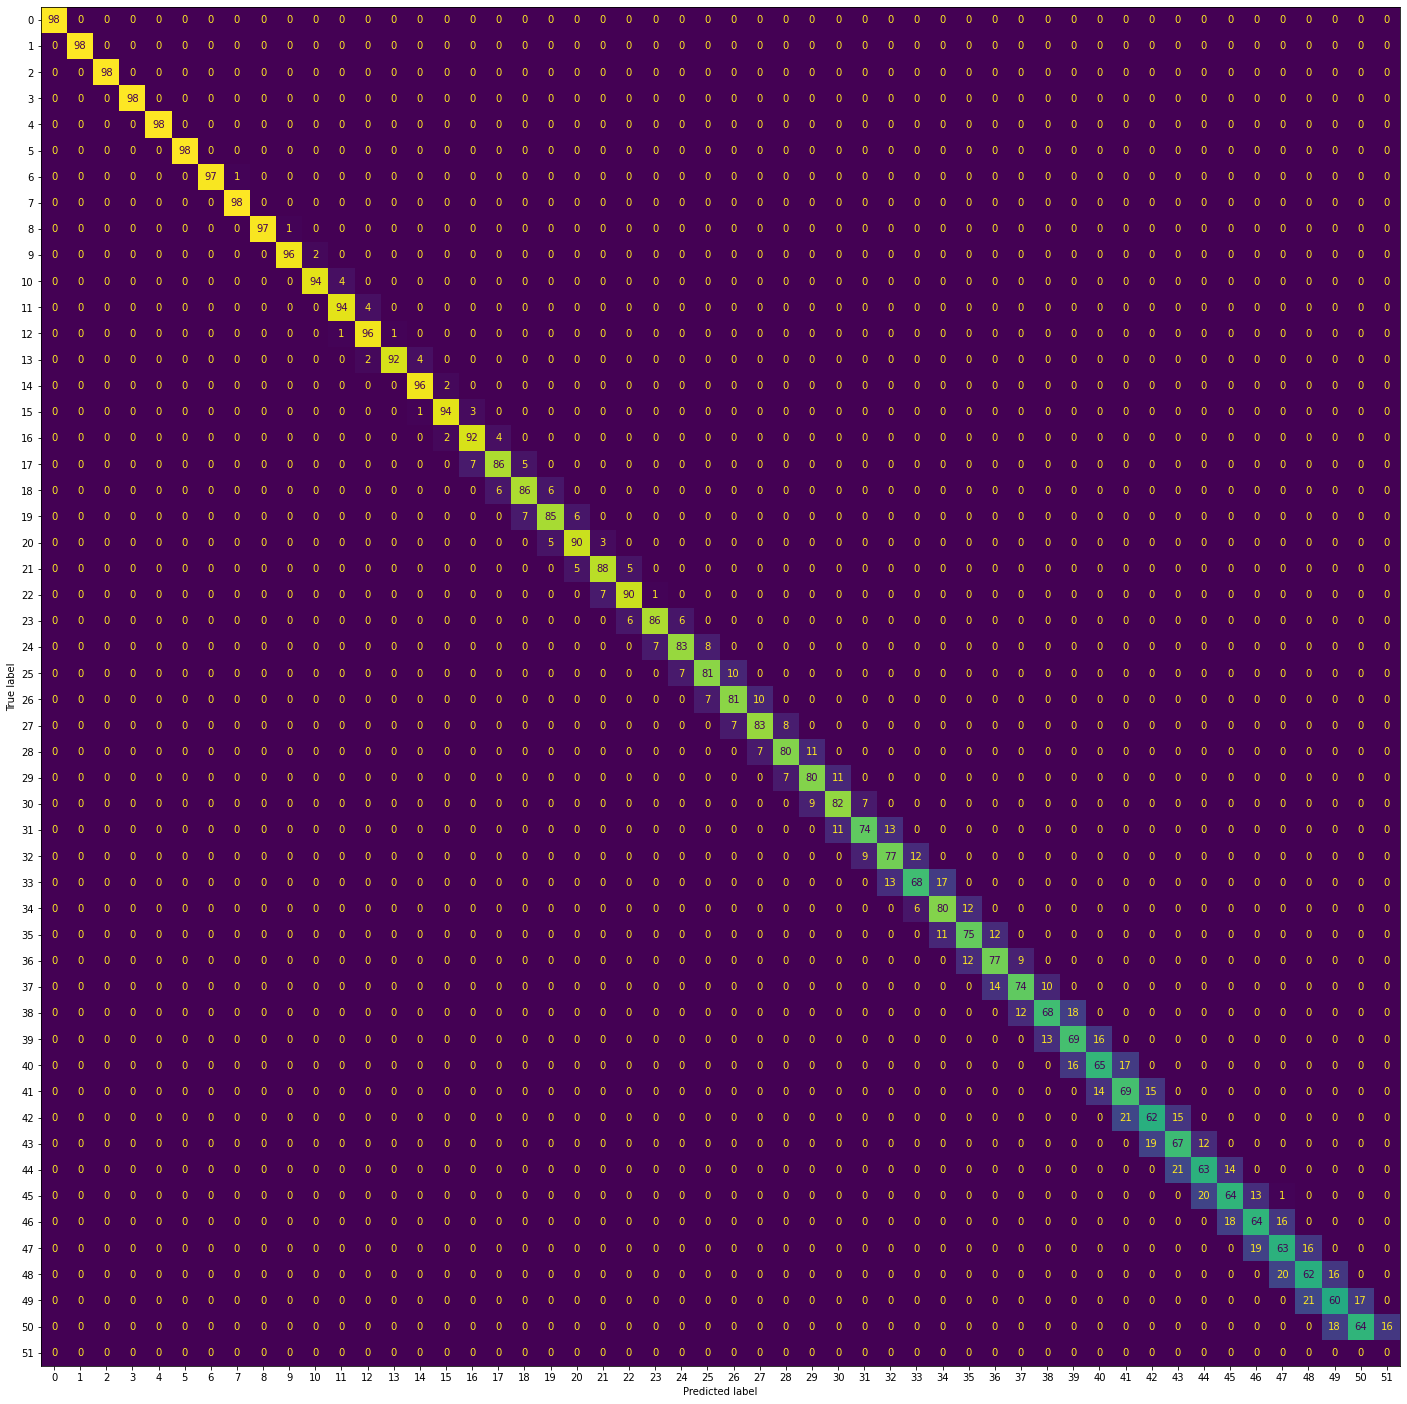

semi-circulo
train 153
test 4998
b = 0.39700465882300406, w = [6.77734543e-05]
Precisão com regressão linear da integral: 0.8905562224889956
Erro Percentual Médio Absoluto com regressão linear da integral: 0.7%
Matriz de confusão com regressão linear da integral


<Figure size 1800x1800 with 0 Axes>

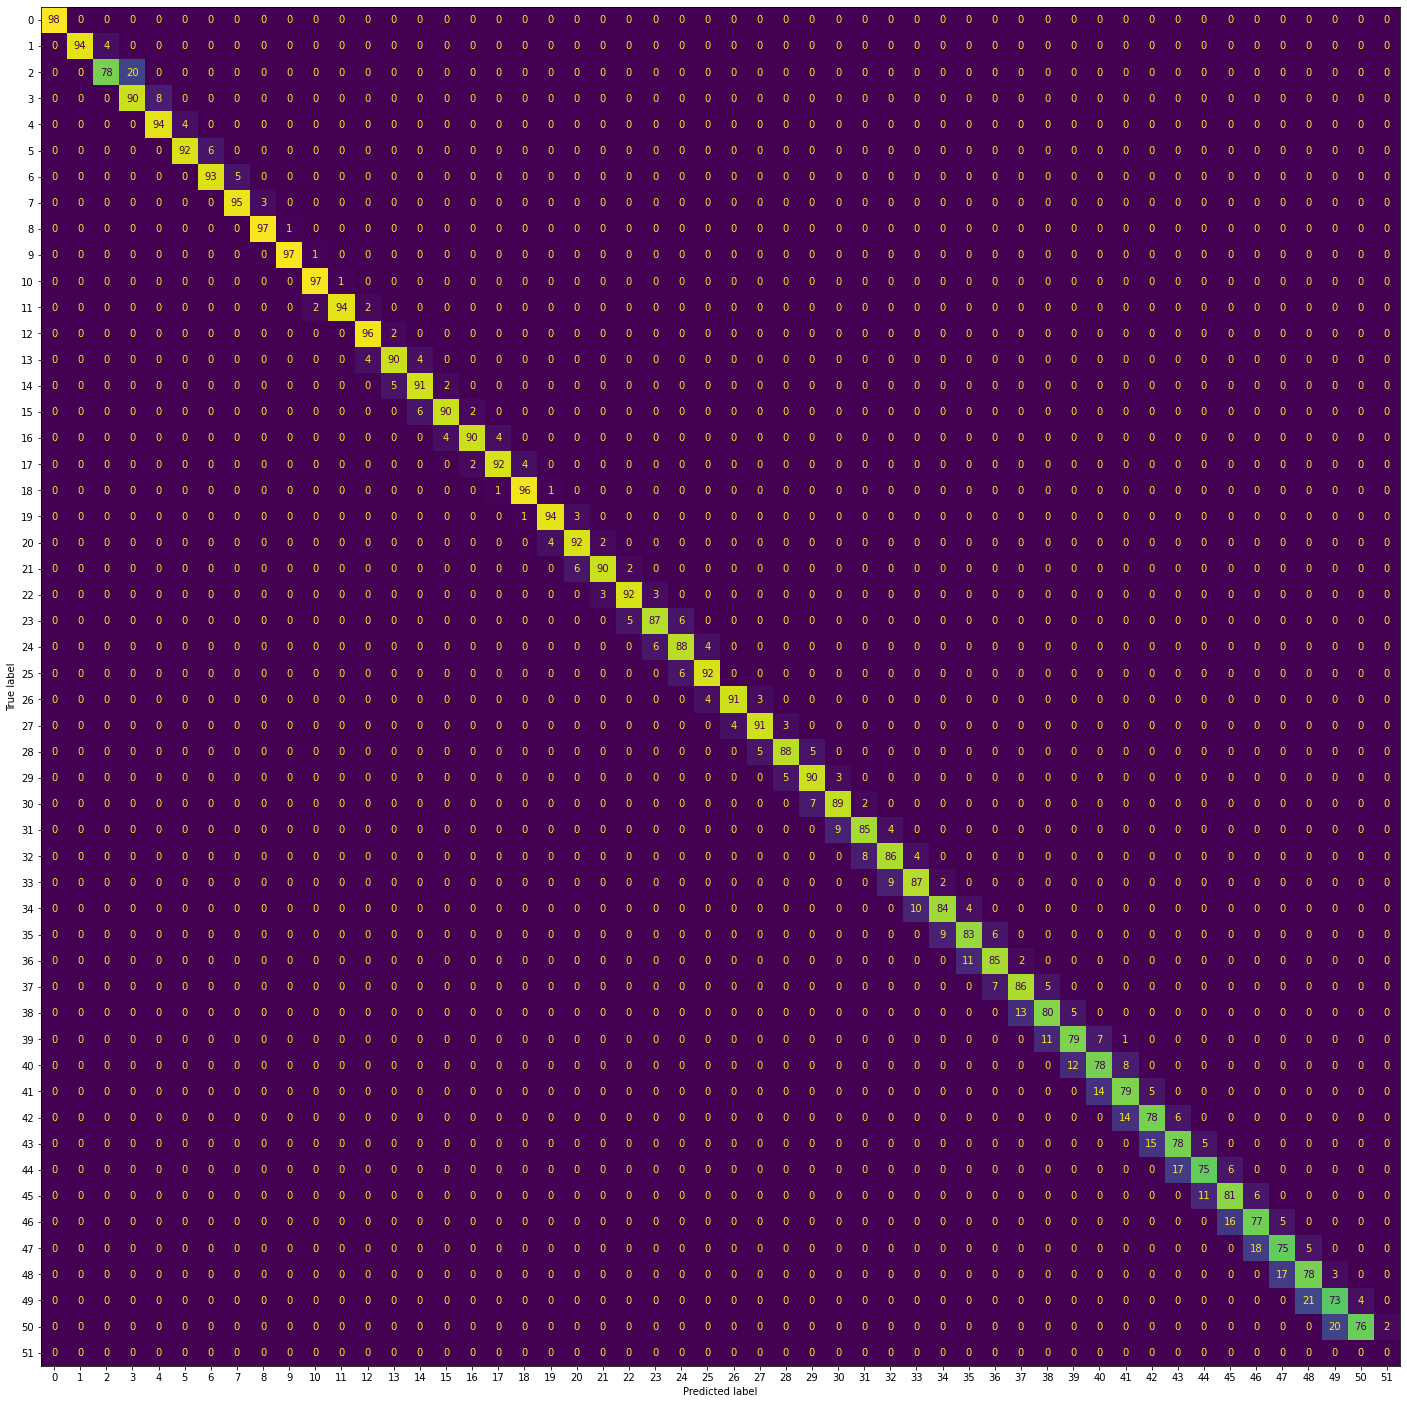

In [170]:
datasets=['circle/circle.json','trapezoid/trapezoid.json',
          'c_sector/c_sector.json','half_circle/half_circle.json']
area_alvo=['circulo','trapezio','secao circular','semi-circulo']

plotfigure=True
plotassign=False

for macroindex in range(len(datasets)):
#for macroindex in range(1):
    df = pd.read_json(datasets[macroindex])

    dfdictlist=[]    
    for index, row in df.iterrows():
        newrow={}
        newrow['file']=row['file']

        pict=np.load(row['file'])
        
        newrow['integral']=int(Image1DAreaIntegral(pict))

        newrow['Y']=row['Y']

        dfdictlist.append(newrow)
        
    print(area_alvo[macroindex])
    df2 = pd.DataFrame.from_dict(dfdictlist)
    
    caixasdetreino=3
    pecasdetreino=51*caixasdetreino
    
    dftrain=df2.iloc[:pecasdetreino]
    dftest=df2.iloc[pecasdetreino:]
    
    print('train',len(dftrain))
    print('test',len(dftest))
    
    x1 = np.expand_dims(dftrain['integral'].to_numpy(), 1)
    y1 = dftrain['Y'].to_numpy()
    
    
    model = LinearRegression()
    model.fit(x1, y1)
    b = model.intercept_
    w = model.coef_
    print(f'b = {b}, w = {w}')
    
    y_pred = model.predict(np.expand_dims(dftest['integral'].to_numpy(), 1))
    
    ypredlist=[]
    for resultado in y_pred:
        ypredlist.append(int(proper_round(resultado)))    

    
    dftest['YPred'] = ypredlist
    
    accuracy=accuracy_score(dftest['Y'],dftest['YPred'])
    MAPE=mean_absolute_percentage_error(dftest['Y'], dftest['YPred'])
    print('Precisão com regressão linear da integral:',accuracy)
    print('Erro Percentual Médio Absoluto com regressão linear da integral:',f'{MAPE:.1%}')
    
    if plotassign == True:
        plt.rcParams['figure.figsize'] = [16, 9] 
        plt.figure()  
        x1 = dftest['Y'].to_numpy()
        y1 = dftest['YPred'].to_numpy()
        plt.plot(x1, y1, 'o', label='Saídas')
        plt.plot([0,50], [0,50], 'r-', label='Ideal')
        plt.xlabel('Valor Real');
        plt.ylabel('Valores Estimados');
        plt.title('correlação - resultado da regressão linear da integral');
        plt.legend();
        plt.show()
        
    if plotfigure == True:

        plt.rcParams['figure.figsize'] = [25,25] 
        print('Matriz de confusão com regressão linear da integral')
        plt.figure()  
        cm_1 = ConfusionMatrixDisplay.from_predictions(y_true=dftest['Y'], y_pred=dftest['YPred'],colorbar=False)
        plt.show()
        

    


        
        
plt.rcParams['figure.figsize'] = [16, 9] 